In [18]:
import numpy as np

THICKNESS = 0.01
YOUNG = 210000
POISSON = 0
ELEMENT_NUM_PER_ROW = 10
ELEMENT_NUM_PER_COL = 4
X_INCREMENT = 5
Y_INCREMENT = 0.5

# 変位拘束
fix_disp_node = np.array([1, 12, 23, 34, 45])
fix_disp_x = np.array([0, 0, 0, 0, 0])
fix_disp_y = np.array([0, 0, 0, 0, 0])
fix_force_node = np.array([11, 22, 33, 44, 55])
fix_force = np.array([-0.0125, -0.025, -0.025, -0.025, -0.0125])


ELEMENTS = ELEMENT_NUM_PER_ROW * ELEMENT_NUM_PER_COL
NODE = (ELEMENT_NUM_PER_ROW+1)*(ELEMENT_NUM_PER_COL+1)

INTEGRAL_POINT4 = 4
NODE_QUAD4 = 4
COMPONENT = 3
DOF_NODE = 2
DOF_TOTAL = NODE*DOF_NODE
DOF_QUAD4 = NODE_QUAD4*DOF_NODE
U = np.zeros(DOF_TOTAL)
Um = np.array([False for i in range(DOF_TOTAL)])
F = np.zeros(DOF_TOTAL)
B = np.zeros((ELEMENTS, COMPONENT, DOF_QUAD4, INTEGRAL_POINT4))
D = np.zeros((COMPONENT, COMPONENT))
mat_detJ = np.zeros((ELEMENTS, INTEGRAL_POINT4))
Ke = np.zeros((ELEMENTS, DOF_QUAD4, DOF_QUAD4))
K = np.zeros((DOF_TOTAL, DOF_TOTAL))
strain_ip = np.zeros((ELEMENTS, INTEGRAL_POINT4, COMPONENT))
stress_ip = np.zeros((ELEMENTS, INTEGRAL_POINT4, COMPONENT))


# 節点番号
min_p1 = 1
max_p1 = ELEMENT_NUM_PER_ROW+(ELEMENT_NUM_PER_ROW+1)*(ELEMENT_NUM_PER_COL-1)
min_p3 = (ELEMENT_NUM_PER_ROW+1)+2
max_p3 = NODE
tot_row_node = ELEMENT_NUM_PER_ROW+1

# 節点番号
p1 = np.array([i for i in range(min_p1, max_p1+1)
               if not i % (tot_row_node) == 0])
p2 = p1+1
p3 = np.array([i for i in range(min_p3, max_p3+1)
               if not (i-1) % (tot_row_node) == 0])
p4 = p3-1
connectivity = np.array([p1, p2, p3, p4], dtype=int).T

# 節点座標
x = np.array([X_INCREMENT*(i % tot_row_node)
              for i in range(NODE)], dtype=float)
y = np.array([Y_INCREMENT*(i // tot_row_node)
              for i in range(NODE)], dtype=float)


Um[(fix_disp_node-1)*DOF_NODE] = True  # x座標
Um[(fix_disp_node-1)*DOF_NODE+1] = True  # y座標

# 拘束条件
# x=(節点番号-1) X 節点の自由度
# y=(節点番号-1) X 節点の自由度+1
F[(fix_force_node-1)*DOF_NODE+1] = fix_force

U[(fix_disp_node-1)*DOF_NODE] = fix_disp_x
U[(fix_disp_node-1)*DOF_NODE+1] = fix_disp_y

# 積分点座標
ip_xi = np.array([-1/np.sqrt(3), 1/np.sqrt(3), -1/np.sqrt(3), 1/np.sqrt(3)])
ip_et = np.array([-1/np.sqrt(3), -1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)])

# 積分点重み
ip_wi = np.array([1, 1, 1, 1])
ip_wj = np.array([1, 1, 1, 1])


def make_D():
    coef = YOUNG/(1-2*POISSON)/(1+POISSON)
    D[0] = coef*np.array([1-POISSON, POISSON, 0])
    D[1] = coef*np.array([POISSON, 1-POISSON, 0])
    D[2] = coef*np.array([0, 0, (1-2*POISSON)/2])


def make_B():
    "Bマトリックスを作成"
    for e in range(ELEMENTS):
        arr_x = x[connectivity[e]-1]
        arr_y = y[connectivity[e]-1]

        dNdXi = np.array([-(1-ip_et), (1-ip_et), (1+ip_et), -(1+ip_et)])/4
        dNdEt = np.array([-(1-ip_xi), -(1+ip_xi), (1+ip_xi), (1-ip_xi)])/4

        dXdXi = np.dot(dNdXi.T, arr_x)
        dYdXi = np.dot(dNdXi.T, arr_y)
        dXdEt = np.dot(dNdEt.T, arr_x)
        dYdEt = np.dot(dNdEt.T, arr_y)

        detJ = dXdXi * dYdEt - dYdXi * dXdEt

        dNdX = (dNdXi*dYdEt-dNdEt*dYdXi)/detJ
        dNdY = (-dNdXi*dXdEt+dNdEt*dXdXi)/detJ

        # 要素Bマトリックスを作成
        # Beマトリックスの１行目.dNdXを奇数列に配置
        Be1 = np.array([np.where(i % 2 == 0, dNdX[i//2], 0)
                        for i in range(DOF_QUAD4)])
        # Beマトリックスの2行目.dNdYを偶数列に配置
        Be2 = np.array([np.where(i % 2 != 0, dNdY[i//2], 0)
                        for i in range(DOF_QUAD4)])
        # Beマトリックスの3行目.dNdYとdNdXを交互に配置
        Be3 = np.array([np.where(i % 2 == 0, dNdY[i//2], dNdX[i//2])
                        for i in range(DOF_QUAD4)])
        # 要素Bマトリックスを追加
        Be = np.array([Be1, Be2, Be3])  # Be(COMP,DOF_QUAD4,INTEGRAL_POINT4)

        # 全体Bマトリックスに追加
        B[e] = Be
        mat_detJ[e] = detJ


def make_Ke():
    for e in range(ELEMENTS):
        for ip in range(INTEGRAL_POINT4):
            Be_ip = B[e][:, :, ip]
            detJ = mat_detJ[e][ip]

            BtD = np.dot(Be_ip.T, D)
            BtDB = np.dot(BtD, Be_ip)
            wi = ip_wi[ip]
            wj = ip_wj[ip]

            Kep = BtDB * detJ * wi * wj * THICKNESS
            Ke[e] += Kep


def make_K():
    for e in range(ELEMENTS):
        for r in range(NODE_QUAD4):
            nr = connectivity[e][r]
            for c in range(NODE_QUAD4):
                nc = connectivity[e][c]
                K[nr*2-2][nc*2-2] += Ke[e][r*2][c*2]
                K[nr*2-2][nc*2-1] += Ke[e][r*2][c*2+1]
                K[nr*2-1][nc*2-2] += Ke[e][r*2+1][c*2]
                K[nr*2-1][nc*2-1] += Ke[e][r*2+1][c*2+1]


def solve_cont_known_var(A, b, x, x_flag):
    x_flag_idx = np.where(x_flag)[0]
    Ac = A.copy()
    Ac[x_flag_idx, x_flag_idx] = 0
    b -= np.sum(Ac[:, x_flag_idx]*x[x_flag_idx], axis=1)

    Ac[:, x_flag_idx] = 0
    Ac[x_flag_idx, :] = 0
    Ac[x_flag_idx, x_flag_idx] = 1

    b[x_flag_idx] = x[x_flag_idx]
    x = np.linalg.solve(Ac, b)
    return x


def calc_Fr(K, U):
    Fr = np.dot(K, U)
    return Fr


def calc_strain():
    Ue = np.zeros((DOF_QUAD4))
    for e in range(ELEMENTS):
        for n in range(NODE_QUAD4):
            Ue[n*2] = U[connectivity[e, n]*2-2]  # x座標
            Ue[n*2+1] = U[connectivity[e, n]*2-1]  # y座標

        for ip in range(INTEGRAL_POINT4):
            strain_ip[e, ip] = np.dot(B[e, :, :, ip], Ue)


def calc_stress():
    for e in range(ELEMENTS):
        for ip in range(INTEGRAL_POINT4):
            stress_ip[e, ip] = np.dot(D, strain_ip[e, ip])


make_B()
make_D()
make_Ke()
make_K()
U = solve_cont_known_var(K, F, U, Um)
Fr = calc_Fr(K, U)
calc_strain()
calc_stress()

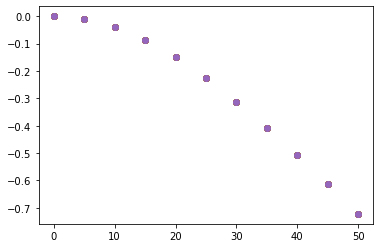

In [19]:
import matplotlib.pyplot as plt
for i in np.array([1,12,23,34,45]):
    node = np.array([i for i in range(i, i+10+1)])
    plt.scatter(x[node-1], U[(node-1)*DOF_NODE+1])

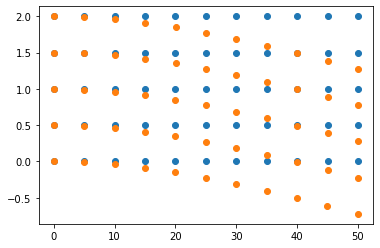

In [20]:
xc = x.copy()
yc = y.copy()
for i in np.array([1, 12, 23, 34, 45]):
    node = np.array([i for i in range(i, i+10+1)])
    yc[node-1] += U[(node-1)*DOF_NODE+1]
    xc[node-1] += U[(node-1)*DOF_NODE]
plt.scatter(x,y)
plt.scatter(xc,yc)

In [27]:
stress_ip.shape

(40, 4, 3)

In [25]:
connectivity[1]

array([ 2,  3, 14, 13])